# Goal

The goal of this notebook is to train a **OBELISK-NET** to output binary mask representing the sella turcica ROI.

With gratitude to 
- https://github.com/mattiaspaul/OBELISK/blob/master/models.py
- https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

TODO
- Augmentations: flip, orientation
- Intensity normalization: N4 bias correction, hist bin matching, tissue intensity,

In [2]:
# OBELISK-NET from github
import sys
sys.path.append('/home/labcomputer/Desktop/Rachel/OBELISK')
from models import obelisk_visceral

In [3]:
# Check GPU stats

from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)
    
# https://docs.fast.ai/dev/gpu.html
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

import torch
print("is cuda available?", torch.cuda.is_available() )
torch.cuda.empty_cache()
torch.cuda.set_device(0)

# hm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Device 0 : b'GeForce GTX 1080 Ti'
Device 1 : b'GeForce GTX 1080'
gpu: 0%, gpu-mem: 0%
is cuda available? True
cuda


In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Data Path

Set path to where data is stored.

In [5]:
import os

In [6]:
# Get path to 4 TB HD

# /media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home

# wsl: /home/rgologorsky/DeepPit
hd_path = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a" + "/home/rachel/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

print(all_folders)

# labels
print(os.listdir(f"{hd_path}/samir_labels"))

['ABIDE', 'PPMI', 'ABVIB', 'samir_labels']
['50155-50212', '50373-50453', '50002-50153', '50213-50312', '50313-50372']


# Imports

In [7]:
# imports

from faimed3d.all import *
from fastai import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk
import meshio

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

from helpers_preprocess import get_data_dict, paths2objs, folder2objs, seg2mask

from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

# imports
from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_viz import viz_axis

# Get Items

Item = (path to MR, path to Segmentation obj)

In [8]:
subset_sz = 10

In [9]:
# get items = (mask_fn, nii_fn)
train_path = f"{hd_path}/samir_labels"
folders = os.listdir(train_path)

# get all items
data_dict_full = {}
for folder in folders:
    data_dict_full.update(get_data_dict(f"{train_path}/{folder}"))

items_full = list(data_dict_full.values())

# subset 300 for training/valid; 35 for test
rand_idx = torch.randperm(subset_sz)
items = np.array(items_full)[rand_idx]

print(f"Full data dict: {len(data_dict_full)} items.")
print(f"Subset data dict: {len(items)} items.")

Full data dict: 335 items.
Subset data dict: 10 items.


# Transforms

- PathToSITK (*convert paths to SITK obj*)
- Resize (*common size, isotropic spacing*)
- ToTensor (*convert to Pytorch tensor*)
- TensorSlice & Center Crop (*slice 3d tensor to center part containing sella*)
- Normalize (*scale image intensities? - diff tissues diff intensities?*)

In [10]:
class DoAll(ItemTransform):
    
    def __init__(self, new_sp = 1):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        folder  = Path(segm_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)

        mr         = sitk.ReadImage(im_path, sitk.sitkFloat32)
        segm       = meshio.read(segm_path)
        mask_arr   = seg2mask(mr, segm, ras_adj)

        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        im = torch.swapaxes(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.tensor(mask_arr).float()

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()


# Crop

In [11]:
# crop center
class CenterCropTfm(Transform):
    def __init__(self, size):
        self.size = size
        
    def encodes(self, arr):
        return self.cropND(arr, self.size)
    
    # https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    @staticmethod
    def cropND(img, bounding):
        start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
        end = tuple(map(operator.add, start, bounding))
        slices = tuple(map(slice, start, end))
        return img[slices]
    
# crop by coords
class CropBBox(Transform):
    def __init__(self, bbox):
        self.bbox = bbox
    
    def encodes(self, arr):
        imin, imax, jmin, jmax, kmin, kmax = self.bbox
        cropped = arr[imin:imax, jmin:jmax, kmin:kmax]
        
        # pad if needed
        new_size = [imax-imin, jmax-jmin, kmax-kmin]
        
        pad = [x-y for x,y in zip(new_size, arr.shape)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        return F.pad(arr, pad, mode='constant', value=0)
    

# add padding
class Pad(Transform):
    def __init__(self, sz):
        self.sz = sz
        
    def encodes(self, arr):
        pad = [x-y for x,y in zip(self.sz, arr.shape)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        return F.pad(arr, pad, mode='constant', value=0)

In [12]:
# from faimed3d 03_transforms.ipynb
def resize_3d(t, size, scale_factor=None,
              mode='trilinear', align_corners=True, recompute_scale_factor=None):
    '''
    A function to resize a 3D image using torch.nn.functional.interpolate

    Args:
        t (Tensor): a 3D or 4D Tensor to be resized
        size (int): a tuple with the new x,y,z dimensions of the tensor after resize
        scale_factor, mode, align_corners, recompute_scale_factor: args from F.interpolate
    Returns:
        A new `Tensor` with Tensor.size = size
    '''
    old_sz = t.shape[-3:]
    if hasattr(t, '_metadata'):
        spacing = t.get_spacing()
        if scale_factor is None:
            change_factors = list(map(operator.truediv, old_sz,  size))
            change_factors.reverse() # spacing is H x W x D, but tensor is D x H x W. As H and W are symmetrical, it is ok to just reverse.
            new_spacing = tuple(map(operator.mul, spacing, change_factors))
        else:
            new_spacing = tuple([x/scale_factor for x in spacing])
        t.set_spacing(new_spacing)

    #if isinstance(t, TensorMask3D): mode = 'nearest'
    if t.ndim == 3: t=t.unsqueeze(0)   # add fake chanel dim
    if t.ndim == 4: t=t.unsqueeze(0)   # add fake batch dim

    t = F.interpolate(t.float(), size=size,
                         scale_factor=scale_factor,
                         mode=mode,
                         align_corners=align_corners,
                         recompute_scale_factor=recompute_scale_factor).squeeze() #remove fake dims

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [13]:
bs  = 2
center_crop_sz = (50, 50, 50)
#pad_sz = (150, 150, 150)
# general_bbox = (40, 150, 100, 320, 0, 300)
# general_bbox = (40, 150, 100, 320, 0, 300)

In [14]:
# splits
splits = RandomSplitter(seed=42)(items)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
#tfms = [DoAll(), CropBBox(general_bbox)]
tfms = [DoAll(), CenterCropTfm(center_crop_sz)]

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=bs, after_batch=AddChannel())

# GPU
dls = dls.cuda()

# test get one batch
b = dls.one_batch()
print(type(b), len(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 8, Valid: 2
<class 'tuple'> 2 torch.Size([2, 1, 50, 50, 50]) torch.Size([2, 1, 50, 50, 50])
4 1


# Metric

Linear combination of Dice and Cross Entropy

In [15]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [16]:
# from mathiaspaul
def dice_coeff(outputs, labels, max_label):
    """
    Evaluation function for Dice score of segmentation overlap
    """
    dice = torch.FloatTensor(max_label-1).fill_(0).to(outputs.device)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = (iflat * tflat).sum()
        dice[label_num-1] = (2. * intersection) / (iflat.sum() + tflat.sum())
    return dice

In [17]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [18]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [19]:
# backbone = efficientnet_b0 #r3d_18 (pretrained?)
# learn    = unet_learner_3d(dls, backbone, n_out=2,  metrics = dice_score,
#                           model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')])

In [20]:
# backbone = efficientnet_b0 #r3d_18 (pretrained?)
# learn    = unet_learner_3d(dls, backbone, n_out=2,  metrics = dice_score)

In [21]:
# unet_learner_3d??

In [22]:
# Learner(
#     dls,
#     model,
#     loss_func=None,
#     opt_func=<function Adam at 0x7f0e60231dd0>,
#     lr=0.001,
#     splitter=<function trainable_params at 0x7f0e6b4618c0>,
#     cbs=None,
#     metrics=None,
#     path=None,
#     model_dir='models',
#     wd=None,
#     wd_bn_bias=False,
#     train_bn=True,
#     moms=(0.95, 0.85, 0.95),
# )

In [31]:
b[0].shape

torch.Size([2, 1, 50, 50, 50])

In [32]:
img_val = b[0]
img_val = F.avg_pool3d(img_val,5,stride=1,padding=2)
img_val = F.avg_pool3d(img_val,5,stride=1,padding=2)
img_val = F.avg_pool3d(img_val,3,stride=1,padding=1)
_,_,D_in1,H_in1,W_in1 = img_val.size()

In [33]:
D_in1,H_in1,W_in1

(50, 50, 50)

In [23]:
full_res = torch.tensor(center_crop_sz).long()
full_res
# full_res = torch.tensor(pad_sz).long()
# full_res

tensor([50, 50, 50])

In [46]:
#original OBELISK model as described in MIDL2018 paper
#contains around 130k trainable parameters and 1024 binary offsets
#most simple Obelisk-Net with one deformable convolution followed by 1x1 Dense-Net
class obelisk_visceral_full(nn.Module):
    def __init__(self,num_labels,full_res):
        super(obelisk_visceral_full, self).__init__()
        self.num_labels = num_labels
        self.full_res = full_res
        D_in1 = full_res[0]; H_in1 = full_res[1]; W_in1 = full_res[2];
        D_in2 = (D_in1+1)//2; H_in2 = (H_in1+1)//2; W_in2 = (W_in1+1)//2; #half resolution
        self.half_res = torch.Tensor([D_in2,H_in2,W_in2]).long(); half_res = self.half_res
        D_in4 = (D_in2+1)//2; H_in4 = (H_in2+1)//2; W_in4 = (W_in2+1)//2; #quarter resolution
        self.quarter_res = torch.Tensor([D_in4,H_in4,W_in4]).long(); quarter_res = self.quarter_res
        
        #Obelisk Layer
        # sample_grid: 1 x    1     x #samples x 1 x 3
        # offsets:     1 x #offsets x     1    x 1 x 3
        
        self.sample_grid1 = F.affine_grid(torch.eye(3,4).unsqueeze(0),torch.Size((1,1,quarter_res[0],quarter_res[1],quarter_res[2])))
        self.sample_grid1.requires_grad = False
        
        #in this model (binary-variant) two spatial offsets are paired 
        self.offset1 = nn.Parameter(torch.randn(1,1024,1,2,3)*0.05)
        
        #Dense-Net with 1x1x1 kernels
        self.LIN1 = nn.Conv3d(1024, 256, 1, bias=False, groups=4) #grouped convolutions
        self.BN1 = nn.BatchNorm3d(256)
        self.LIN2 = nn.Conv3d(256, 128, 1, bias=False)
        self.BN2 = nn.BatchNorm3d(128)
        
        self.LIN3a = nn.Conv3d(128, 32, 1,bias=False)
        self.BN3a = nn.BatchNorm3d(128+32)
        self.LIN3b = nn.Conv3d(128+32, 32, 1,bias=False)
        self.BN3b = nn.BatchNorm3d(128+64)
        self.LIN3c = nn.Conv3d(128+64, 32, 1,bias=False)
        self.BN3c = nn.BatchNorm3d(128+96)
        self.LIN3d = nn.Conv3d(128+96, 32, 1,bias=False)
        self.BN3d = nn.BatchNorm3d(256)
        
        self.LIN4 = nn.Conv3d(256, num_labels,1)

        
    def forward(self, inputImg, sample_grid=None):
    
        B,C,D,H,W = inputImg.size()
        if(sample_grid is None):
            sample_grid = self.sample_grid1
        sample_grid = sample_grid.to(inputImg.device)    
        #pre-smooth image (has to be done in advance for original models )
        #x00 = F.avg_pool3d(inputImg,3,padding=1,stride=1)
        
        _,D_grid,H_grid,W_grid,_ = sample_grid.size()
        input = F.grid_sample(inputImg, (sample_grid.view(1,1,-1,1,3).repeat(B,1,1,1,1) + self.offset1[:,:,:,0:1,:])).view(B,-1,D_grid,H_grid,W_grid)-\
        F.grid_sample(inputImg, (sample_grid.view(1,1,-1,1,3).repeat(B,1,1,1,1) + self.offset1[:,:,:,1:2,:])).view(B,-1,D_grid,H_grid,W_grid)
        
        x1 = F.relu(self.BN1(self.LIN1(input)))
        x2 = self.BN2(self.LIN2(x1))
        
        x3a = torch.cat((x2,F.relu(self.LIN3a(x2))),dim=1)
        x3b = torch.cat((x3a,F.relu(self.LIN3b(self.BN3a(x3a)))),dim=1)
        x3c = torch.cat((x3b,F.relu(self.LIN3c(self.BN3b(x3b)))),dim=1)
        x3d = torch.cat((x3c,F.relu(self.LIN3d(self.BN3c(x3c)))),dim=1)

        x4 = self.LIN4(self.BN3d(x3d))
        #return half-resolution segmentation/prediction 
        
        #return x4
        return F.interpolate(x4, size=[self.full_res[0], self.full_res[1], self.full_res[2]], mode='trilinear',align_corners=False)
        #return F.interpolate(x4, size=[self.half_res[0],self.half_res[1],self.half_res[2]], mode='trilinear',align_corners=False)


In [52]:
from models import obeliskhybrid_visceral

In [58]:
DiceLoss??

In [59]:
# D_in1 = imgs.size(2); H_in1 = imgs.size(3); W_in1 = imgs.size(4); #full resolution
# full_res = torch.Tensor([D_in1,H_in1,W_in1]).long()

# _,_,D_in1,H_in1,W_in1 = img_val.size()
# full_res = torch.Tensor([D_in1,H_in1,W_in1]).long()

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= DiceLoss(), #nn.CrossEntropyLoss(), \
                metrics = dice_score)


In [60]:
# with learn.distrib_ctx():
#     learn.fit_one_cycle(1, 3e-1, wd = 1e-4)

In [61]:
# GPU
#learn.model = nn.DataParallel(learn.model)
learn.model = learn.model.cuda()
#learn = learn.to_fp16()

In [62]:
# test:

#dls.device = "cpu"

start = time.time()

x,y = dls.one_batch()
#x,y = to_cpu(x), to_cpu(y)

pred = learn.model(x)
loss = learn.loss_func(pred, y)

elapsed = time.time() - start

print(f"Elapsed: {elapsed} s")
print("Batch: x,y")
print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

print("Pred shape")
print(type(pred), pred.shape, pred.dtype)

print("Loss")
print(loss)
print(learn.loss_func)

Elapsed: 2.0201492309570312 s
Batch: x,y
<class 'torch.Tensor'> torch.Size([2, 1, 50, 50, 50]) torch.float32 
 <class 'torch.Tensor'> torch.Size([2, 1, 50, 50, 50]) torch.int64
Pred shape
<class 'torch.Tensor'> torch.Size([2, 2, 50, 50, 50]) torch.float32
Loss
tensor(0.4694, device='cuda:0', grad_fn=<MeanBackward0>)


In [63]:
x.shape, y.shape, pred.shape

(torch.Size([2, 1, 50, 50, 50]),
 torch.Size([2, 1, 50, 50, 50]),
 torch.Size([2, 2, 50, 50, 50]))

In [64]:
# torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

# LR Finder

In [65]:
#learn.lr_find()

In [66]:
print("PRE learn.fit one cycle")
learn.fit_one_cycle(1, 3e-1, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,0.447691,0.940130,0.114808,00:07


In [67]:
print("unfreeze, learn 50")
learn.unfreeze()
learn.fit_one_cycle(50, 3e-3, wd = 1e-4)

unfreeze, learn 50


epoch,train_loss,valid_loss,dice_score,time
0,0.414686,0.535622,0.221014,00:07
1,0.388065,0.381264,0.349142,00:07
2,0.376620,0.350094,0.393100,00:07
3,0.364497,0.366397,0.389907,00:07
4,0.367923,0.377101,0.399783,00:07
5,0.357440,0.378759,0.412649,00:07
6,0.344720,0.370492,0.459223,00:07
7,0.332658,0.361295,0.511182,00:07
8,0.331257,0.357495,0.494907,00:07
9,0.317740,0.352300,0.488051,00:07


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

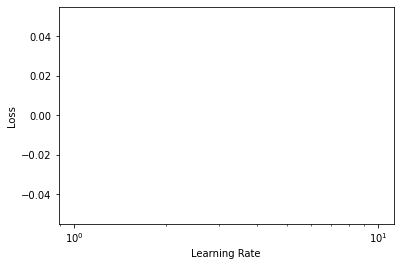

In [72]:
learn.lr_find()

In [ ]:
print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [137]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [138]:
# testmaskN = np.array(testmask)
# testmaskN

In [139]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [140]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [141]:
# maskT.shape, maskN.shape

In [142]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [143]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1